## Импорт библиотек

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Важные переменные

In [29]:
img_folder = '/content/drive/MyDrive/ecodata/elm'
img_names = os.listdir(img_folder)

## Pipeline решения
1. Загрузка изображения (grayscale + rgb).
2. Бинаризация.
3. Убираем жилки и шум (erode/dilate).
4. Ищем контуры.
5. Сохраняем только нужные контуры (контуры эталонов-ограничителей и листьев). Для каждого контура получаем минимальный по площади ограничивающий прямоугольник. Находим эталоны так: сравниваем отношение площадей контуров и минимальных по площади ограничивающих прямоугольников или просто по размеру смотрим (в пределах 120px). Сохраняем контуры листьев и эталонов отдельно.
6. Сортируем контуры листьев и контуры эталонов отдельно (посторочно).
7. Фиксируем площади эталонов (или прямоугольников для них ???), ищем среднюю длину $\frac{1}{n}\sum_{i=0}^n \sqrt{S_{\text{rect}}} $, округляем к ближайшему целому. Вводим константу **FIRST_STANDARD_1mm**, которая равна средней длине стороны квадратного эталона на исходной фотографии, деленной на 10.

Для каждого листа
1. Вырезаем контуры по ограничивающему прямоугольнику $M$. Всё, что внутри $M$, но вне контура листа, закрашиваем в белый, чтобы стало меньше шума. Накладываем полученный прямоугольник на квадратную матрицу $B = 255 A_{n \times n \times 3}$, $n = max(h, w) + k$, где $A$ --- трехмерный тензор, заполненный единицами $h, w$ --- длина и ширина изображения соответственно, $k$ --- внутренний отступ от границы bounding box'а до границы новой матрицы.
2. Поворачиваем $M$ так, чтобы угол нижней стороны и оси X был равен 0. Сохраняем полученное изображение.

Нам нужно будет перемещаться между размерами, можно хранить размеры до ресайза и после него, фотку, айди контура.

В преобразованной фотке нам надо будет выделить жилки, повернуть листочек, чтобы он был посерединке (аппроксимировать главную жилку и сделать её перпендикулярной оси X). После этого нужно найти основные характеристики листа и посчитать их в мм.

Пока надо просто получить хотя бы одну такую фотку.


<!-- <ol>
<li> sad</li>
<li> sab
  <ol>
  <li> sd</li>
  </ol>
 </li>
</ol> -->

**TODO:**
1. Настроить порядок отображения листов.
2. Сделать подсветку листа.
3. Выводить информацию о порядковом номере листа.
4. Делать легенду с отображением текущего масштаба.
5. ПОКА НЕ НАДО, но может пригодиться для нейронки. Применяем resize: преобразуем изображение к размеру $512 \times 512$. Сохраняем все такие изображения в отдельную папку.
```
    # # 5. Изменение размера изображения
    # resized_img = cv2.resize(white_background,
        output_size,
        interpolation=cv2.INTER_AREA)  # Используем INTER_AREA для уменьшения
```
6. Запоминаем масштаб: делим длину и ширину $M$ на **FIRST_STANDARD_1mm**, получаем длину и ширину прямоугольника $M$ в миллиметрах.

## Функции

In [30]:
def erode_dilate_loop(img):
  structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  eroded_image = None

  for _ in range(4):
    eroded_image = cv2.erode(img, structuring_element, iterations=1)
    eroded_image = cv2.dilate(eroded_image, structuring_element, iterations=1)

  return eroded_image

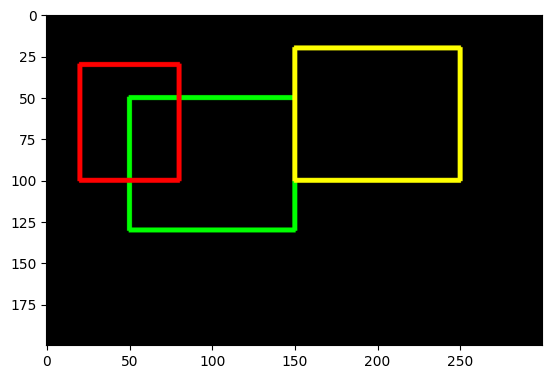

In [31]:
import cv2
import numpy as np

def box_to_contour(box):
    """
    Converts a bounding box representation to a contour.

    Args:
        box: A list or tuple representing the bounding box.  It can be represented
             in different formats:
             - (x, y, width, height)  (standard OpenCV bounding box format)
             - ((x1, y1), (x2, y2))  (top-left and bottom-right points)
             - [(x1, y1), (x2, y2), (x3, y3), (x4, y4)] (four corner points)

    Returns:
        A NumPy array representing the contour.
    """

    # Check the format of the box and convert it to four corner points
    if len(box) == 4 and isinstance(box[0], (int, float)):  # (x, y, width, height)
        x, y, w, h = box
        pts = np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]], np.int32)
    elif len(box) == 2 and isinstance(box[0], (tuple, list)) and len(box[0]) == 2 and isinstance(box[0][0], (int, float)): # ((x1, y1), (x2, y2))
        (x1, y1), (x2, y2) = box
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], np.int32)
    elif len(box) == 4 and isinstance(box[0], (tuple, list)) and len(box[0]) == 2 and isinstance(box[0][0], (int, float)): # [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        pts = np.array(box, np.int32)
    else:
        raise ValueError("Invalid box format.  Supported formats are: (x, y, width, height), ((x1, y1), (x2, y2)), or [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]")


    # Reshape the points to the correct format for contours
    pts = pts.reshape((-1, 1, 2))  # (Number of points, 1, 2)
    return pts

# Example usage:
if __name__ == '__main__':
    # Create a sample image (for demonstration)
    img = np.zeros((200, 300, 3), dtype=np.uint8)  # Black image

    # Example 1: (x, y, width, height) format
    box1 = (50, 50, 100, 80)
    contour1 = box_to_contour(box1)
    cv2.drawContours(img, [contour1], -1, (0, 255, 0), 2)  # Draw a green rectangle

    # Example 2: ((x1, y1), (x2, y2)) format
    box2 = ((20, 30), (80, 100))
    contour2 = box_to_contour(box2)
    cv2.drawContours(img, [contour2], -1, (255, 0, 0), 2)  # Draw a blue rectangle

    # Example 3:  [(x1, y1), (x2, y2), (x3, y3), (x4, y4)] format
    box3 = [(150, 20), (250, 20), (250, 100), (150, 100)]
    contour3 = box_to_contour(box3)
    cv2.drawContours(img, [contour3], -1, (255, 255, 0), 2)  # Draw a cyan rectangle



    # Display the image
    plt.imshow(img)

In [32]:
def bounding_rect_to_contour(rect):
    x, y, w, h = rect
    pts = np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    return pts


In [33]:
def load_image_rgb_grayscale(img_path):
  elm_img = cv2.imread(img_path)
  elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
  elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
  return elm_img_rgb, elm_img_gray

def binarize(img):
  _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
  return thresh1

def compute_standards_side(areas):
  return sum([area ** 0.5 for area in areas]) / len(areas)

def filter_contours_n_bboxes(contours, side_threshold=100, std_threshold=500):
  # откинуть мелочь
  # найти эталоны
  # откинуть крупные
  # реализуем идею со сравнением площади внутри контура и площади minAreaRect
  areas_diffs = []
  widths = []
  for i, c in enumerate(contours):
    box = cv2.boundingRect(c)
    if box[2] >= side_threshold and box[3] >= side_threshold:
        width = box[2]
        box = bounding_rect_to_contour(box)
        rect = cv2.minAreaRect(c)
        area1 = cv2.contourArea(c)
        area2 = rect[1][0] * rect[1][1]  # Width * Height
        diff = abs(area1-area2)
        areas_diffs.append((diff, i, area1, width, box))

  areas_diffs.sort()
  _, idxs, areas, widths, boxes = zip(*areas_diffs)
  # print(areas_diffs, standard_idxs)
  # print(standard_idxs, len(boxes), len(contours))
  # print(*areas_diffs, sep='\n')
  standards_areas = areas[:4]
  standards =  [(boxes[i], contours[j]) for i, j in enumerate(idxs[:4])]
  standards_mean_side_mm = round(compute_standards_side(standards_areas)) / 10
  idxs, widths = zip(*sorted(zip(idxs[4:], widths[4:]), key=lambda x: x[1]))

  for i in range(len(widths)-1, 0, -1):
    if int(widths[i] // widths[i-1]) >= 3:
    #   print(widths[i] , widths[i-1] , widths)
      crop_idx = i
    #   print('crop_idx', crop_idx)
      break

  leaves = [(boxes[i], contours[j]) for i, j in enumerate(idxs)]
  if crop_idx:
    leaves = leaves[:crop_idx+1]

  return standards, leaves, standards_mean_side_mm

In [49]:
# по идее берем каждый bbox и смотрим центроид, через него проводим линию и ищем соседей
# когда нашли соседей, то говорим, что у них тоже есть сосед
# у каждого соседа есть имя - его исходный индекс в списке
# потом соседей внутри группы сортируем по центроиду

def find_neighbours(bboxes, centroids):
    neighbours = dict([(i, set()) for i in range(len(bboxes))])
    for i, centroid1 in enumerate(centroids):
        # box[0][point_idx: i from [1; 4], 0, x:0 or y:1]
        # для строки в матрице строка изменяется от y_min до y_max
        # а столбец от x_min до x_max

        # y1 = centroid y
        # if y_min <= y1 <= y_max: - neighbour
        y1 = centroid1[1]
        for j, (bbox2, centroid2) in enumerate(zip(bboxes, centroids)):
            if i == j:
                continue
            print(bbox2)
            x_min, y_max = bbox2[0][0]
            x_max, y_min = bbox2[2][0]
            if y_min <= y1 <= y_max:
                neighbours[(centroid1, i)].add((centroid2, j))
                neighbours[(centroid2, j)].add((centroid1, i))
    return neighbours

def sort_neighbours(neighbours):
    neighbours_sorted = []
    for k, v in neighbours.items():
        neighbours_sorted.append(sorted(list(v), key=lambda x: x[0][0]))
    neighbours_sorted.sort(key=lambda x: max(x, key=lambda y: y[0][0]))
    return neighbours_sorted

def bboxes_to_centroids(bboxes):
    centroids = []
    for box in bboxes:
        M = cv2.moments(box)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx, cy))
    return centroids

In [35]:
def get_indexes_of_sorted_bboxes(bboxes):
    centroids = bboxes_to_centroids(bboxes)
    neighbours = find_neighbours(bboxes, centroids)
    neighbours_sorted = sort_neighbours(neighbours)
    idxs = []
    for group in neighbours_sorted:
        # [((cx11, cy21), 0), ((cx12, cy22), 1), ...]
        for (centroid, i) in group:
            idxs.append(i)
    return idxs


In [36]:
def sort_bboxes_n_contours_left_to_right_get_bboxes(contours, bboxes):
    # Сортируем контуры по координате X верхнего левого угла ограничивающего прямоугольника (слева направо)
    # находим соседей bbox'а в отсортированном порядке
    # (contours, bboxes) = zip(*sorted(zip(contours, bboxes),
    #                                         key=lambda b: b[0][0, 0, 1],  # b[1][0] - это x координата
    #                                         reverse=False))  # reverse=False для порядка слева направо

    idxs = get_indexes_of_sorted_bboxes(bboxes)
    bboxes = [bbox[i] for i in idxs]
    contours = [contour[i] for i in idxs]

    return contours, bboxes

In [37]:
def fill_outside_contour(img, contour):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    mask_inv = cv2.bitwise_not(mask)
    white_background = np.full(img.shape, (255, 255, 255), dtype=np.uint8)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    masked_background = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
    result = cv2.bitwise_or(masked_img, masked_background)
    return result

In [38]:
def crop_add_to_matrix_with_contour_transform(img, x1, y1, x2, y2, contour, padding=100):
    cropped_img = img[y1:y2, x1:x2]
    transformed_contour = contour.copy()
    transformed_contour[:, :, 0] -= x1
    transformed_contour[:, :, 1] -= y1

    cropped_img = fill_outside_contour(cropped_img, transformed_contour)

    height, width = cropped_img.shape[:2]
    max_dim = max(height, width) + padding

    white_background = np.full((max_dim, max_dim, 3), 255, dtype=np.uint8)
    x_offset = (max_dim - width) // 2
    y_offset = (max_dim - height) // 2
    white_background[y_offset:y_offset + height,
                     x_offset:x_offset + width] = cropped_img

    transformed_contour[:, :, 0] += x_offset
    transformed_contour[:, :, 1] += y_offset

    return white_background, transformed_contour

In [39]:
def rotate_image_and_fill(img, contour):
    rect = cv2.minAreaRect(contour)
    center, (width, height), angle = rect

    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rows, cols = img.shape[:2]
    new_img = cv2.warpAffine(img,
                             rot_mat,
                             (rows, cols),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(255, 255, 255))

    return new_img

## Черновики

In [40]:
# def load_image_rgb_grayscale(img_path):
#   elm_img = cv2.imread(img_path)
#   elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
#   elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
#   return elm_img_rgb, elm_img_gray

# def binarize(img):
#   _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
#   return thresh1

# def compute_standards_side(areas):
#   return sum([area ** 0.5 for area in areas]) / len(areas)

# def filter_contours_n_bboxes(contours, side_threshold=100, std_threshold=500):
#   boxes = []
#   cs = []
#   # откинуть мелочь
#   # найти эталоны
#   # откинуть крупные
#   # реализуем идею со сравнением площади внутри контура и площади minAreaRect
#   areas_diffs = []
#   widths = []
#   for i, c in enumerate(contours):
#     box = cv2.boundingRect(c)
#     if box[2] >= side_threshold and box[3] >= side_threshold:
#         width = box[2]
#         box = bounding_rect_to_contour(box)
#         boxes.append((box, i))
#         area1 = cv2.contourArea(c)
#         area2 = cv2.contourArea(box)
#         diff = abs(area1-area2)
#         areas_diffs.append((diff, i, area2, width))

#   areas_diffs.sort()
#   _, idxs, areas, widths = zip(*areas_diffs)
#   # print(areas_diffs, standard_idxs)
#   # print(standard_idxs, len(boxes), len(contours))
#   standards_areas = areas[:4]
#   standards =  [(boxes[i], contours[j]) for i, j in enumerate(idxs[:4])]
#   standards_mean_side = round(compute_standards_side(standards_areas)) / 10
#   print(standards_mean_side)
#   crop_idx = 0

#   tmp = np.array(widths[4:])
#   for i in range(len(widths)-1, -1, -1):
#     std_before = tmp.std()
#     tmp = np.delete(tmp, -1)
#     std_after = tmp.std()
#     print(std_before, std_after)
#     if abs(std_before - std_after) >= std_threshold:
#       print('crop_idx', crop_idx)
#       crop_idx = i
#       break

#   leaves = [(boxes[i+4], contours[j]) for i, j in enumerate(idxs[4:])]
#   if crop_idx:
#     leaves = leaves[:crop_idx]

#   return standards, leaves, standards_mean_side

In [41]:
# def fill_area_outside_contour(img, contour):
#     mask = np.zeros(img.shape[:2], dtype=np.uint8)
#     cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
#     mask_inv = cv2.bitwise_not(mask)
#     image_masked = cv2.bitwise_and(img, img, mask=mask)
#     # Создание белого фона
#     white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

#     # Добавляем белый фон за пределами контуров
#     background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

#     # Объединяем контуры с исходным изображением и белый фон
#     final_result = cv2.bitwise_or(image_masked, background_masked)
#     plt.imshow(final_result)

# def fill_outside_contour(image_path, output_path="filled_image.jpg"):
#     if contours:
#         largest_contour = max(contours, key=cv2.contourArea)
#         mask = np.zeros(img.shape[:2], dtype=np.uint8)
#         cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
#         mask_inv = cv2.bitwise_not(mask)
#         white_background = np.full(img.shape, (255, 255, 255), dtype=np.uint8)
#         masked_img = cv2.bitwise_and(img, img, mask=mask)
#         masked_background = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
#         result = cv2.bitwise_or(masked_img, masked_background)

In [42]:
# def crop_add_to_matrix(img, x1, y1, x2, y2, padding=100):
#     cropped_img = img[y1:y2, x1:x2]
#     height, width = cropped_img.shape[:2]
#     max_dim = max(height, width) + padding

#     white_background = np.full((max_dim, max_dim, 3), 255, dtype=np.uint8)
#     x_offset = (max_dim - width) // 2
#     y_offset = (max_dim - height) // 2
#     white_background[y_offset:y_offset+height,
#                      x_offset:x_offset+width] = cropped_img

#     return white_background, offset_contour

In [43]:
# mask = np.zeros(elm_img_rgb.shape[:2], dtype=np.uint8)
# cv2.drawContours(mask, cs, 2, 255, cv2.FILLED)
# # Инвертирование маски: контуры черные, все остальное - белое
# mask_inv = cv2.bitwise_not(mask)

# # Сохраняем исходное изображение внутри контуров
# image_masked = cv2.bitwise_and(elm_img_rgb, elm_img_rgb, mask=mask)
# # Создание белого фона
# white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

# # Добавляем белый фон за пределами контуров
# background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

# # Объединяем контуры с исходным изображением и белый фон
# final_result = cv2.bitwise_or(image_masked, background_masked)
# plt.imshow(final_result)

In [44]:
# def load_image_rgb_grayscale(img_path):
#   elm_img = cv2.imread(img_path)
#   elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
#   elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
#   return elm_img_rgb, elm_img_gray

# def binarize(img):
#   _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
#   return thresh1

# def filter_contours_get_bboxes(contours, side_threshold=100, std_threshold=100):
#   boxes = []
#   cs = []
#   for i, c in enumerate(contours):
#     rect = cv2.minAreaRect(c)
#     box = cv2.boxPoints(rect).astype(int)
#     boxes.append((box, i))

#   arr = list(filter(lambda x: x[0][2] >= side_threshold and x[0][3] >= side_threshold, boxes))
#   arr = np.array(sorted(arr, key=lambda x: x[0][2], reverse=True))
#   standards = arr[-4:]
#   widths = arr[:-4, 0, 2]
#   crop_idx = 0
#   i = 0
#   while i < len(arr)-4:
#     std_before = widths.std()
#     widths.pop(i)
#     std_after = widths.std()
#     if abs(std_before - std_after) >= std_threshold:
#       crop_idx = i
#     i += 1

#   arr = arr[crop_idx:]
#   for v, i in arr:
#     cs.append(contours[i])

#   return arr, cs



# # def filter_contours_get_bboxes(contours):
# #   boxes = []
# #   for i, c in enumerate(contours):
# #     rect = cv2.minAreaRect(c)
# #     box = cv2.boxPoints(rect).astype(int)
# #     boxes.append((box, i))

# #   arr = list(filter(lambda x: x[0][2] >= 100 and x[0][3] >= 100, boxes))
# #   arr = np.array(sorted(arr, key=lambda x: x[0][2], reverse=True))
# #   standards =
# #   indx = np.indmax(arr[:, 0, 2]
# #   return

# #   bboxes_contours_dict = {x[1]: {'box': x[0]} for x in arr}

# #   for i, v in cs:
# #     cs.append(contours[i])
# #   cs.sort(key=lambda x: x.max(axis=0)[0][1])

## Решение

In [50]:
img_path = os.path.join(img_folder, img_names[0])
elm_img_rgb, elm_img_gray = load_image_rgb_grayscale(img_path)
bin_img = binarize(elm_img_gray)
eroded_img = erode_dilate_loop(bin_img)
contours, _ = cv2.findContours(eroded_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
standards, leaves, FIRST_STANDARD_1mm = filter_contours_n_bboxes(contours, side_threshold=100, std_threshold=500)
standards_rects, standards_contours = zip(*standards)
leaves_rects, leaves_contours = zip(*leaves)
print(len(standards), len(leaves))
standards_contours, standards_bboxes = sort_bboxes_n_contours_left_to_right_get_bboxes(standards_contours,
                                                                                                        standards_rects)
leaves_contours, leaves_bboxes = sort_bboxes_n_contours_left_to_right_get_bboxes(leaves_contours,
                                                                                               leaves_rects)
print(leaves_bboxes[0])
for contour, bbox in zip(leaves_contours, leaves_bboxes):
    plt.imshow(cv2.drawContours(elm_img_rgb, contour, -1, (255, 0, 0), 5))
    plt.show()
    x1, y1 = bbox[0][0]
    x2, y2 = bbox[2][0]
    leaf_white_bg, transformed_leaf_contour = crop_add_to_matrix_with_contour_transform(elm_img_rgb,
                                                                                    x1, y1, x2, y2, contour, padding=100)
    # plt.imshow(cv2.drawContours(elm_img_rgb, [transformed_leaf_contour], -1, (255, 0, 0), 5))
    # plt.show()
    # plt.imshow(leaf_white_bg)
    # plt.show()
    # leaf_white_bg = rotate_image_and_fill(leaf_white_bg, transformed_leaf_contour)
    # plt.imshow(leaf_white_bg)
    # plt.show()


4 15
[[[2069  337]]

 [[2191  337]]

 [[2191  458]]

 [[2069  458]]]
[[[242 338]]

 [[364 338]]

 [[364 459]]

 [[242 459]]]
[[[2071 2910]]

 [[2194 2910]]

 [[2194 3032]]

 [[2071 3032]]]
[[[ 245 2905]]

 [[ 366 2905]]

 [[ 366 3027]]

 [[ 245 3027]]]
[[[242 338]]

 [[364 338]]

 [[364 459]]

 [[242 459]]]
[[[2071 2910]]

 [[2194 2910]]

 [[2194 3032]]

 [[2071 3032]]]
[[[ 245 2905]]

 [[ 366 2905]]

 [[ 366 3027]]

 [[ 245 3027]]]
[[[2069  337]]

 [[2191  337]]

 [[2191  458]]

 [[2069  458]]]
[[[2071 2910]]

 [[2194 2910]]

 [[2194 3032]]

 [[2071 3032]]]
[[[ 245 2905]]

 [[ 366 2905]]

 [[ 366 3027]]

 [[ 245 3027]]]
[[[2069  337]]

 [[2191  337]]

 [[2191  458]]

 [[2069  458]]]
[[[242 338]]

 [[364 338]]

 [[364 459]]

 [[242 459]]]


ValueError: max() arg is an empty sequence

In [17]:
contours[3]

array([[[ 247, 2905]],

       [[ 351, 2905]],

       [[ 352, 2906]],

       [[ 363, 2906]],

       [[ 364, 2907]],

       [[ 364, 2911]],

       [[ 365, 2912]],

       [[ 365, 2972]],

       [[ 364, 2973]],

       [[ 364, 2983]],

       [[ 365, 2984]],

       [[ 364, 2985]],

       [[ 364, 2990]],

       [[ 365, 2991]],

       [[ 364, 2992]],

       [[ 364, 2997]],

       [[ 365, 2998]],

       [[ 365, 3000]],

       [[ 364, 3001]],

       [[ 364, 3007]],

       [[ 365, 3008]],

       [[ 364, 3009]],

       [[ 364, 3015]],

       [[ 365, 3016]],

       [[ 365, 3022]],

       [[ 364, 3023]],

       [[ 364, 3024]],

       [[ 363, 3025]],

       [[ 352, 3025]],

       [[ 351, 3026]],

       [[ 350, 3025]],

       [[ 345, 3025]],

       [[ 344, 3026]],

       [[ 337, 3026]],

       [[ 336, 3025]],

       [[ 328, 3025]],

       [[ 327, 3026]],

       [[ 322, 3026]],

       [[ 321, 3025]],

       [[ 312, 3025]],

       [[ 311, 3026]],

       [[ 310, 3

In [18]:
thresh1 = np.where(eroded_image == 255, 1, 0)

NameError: name 'eroded_image' is not defined

In [ ]:
mask = np.zeros(elm_img_rgb.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, cs, 2, 255, cv2.FILLED)
# Инвертирование маски: контуры черные, все остальное - белое
mask_inv = cv2.bitwise_not(mask)

# Сохраняем исходное изображение внутри контуров
image_masked = cv2.bitwise_and(elm_img_rgb, elm_img_rgb, mask=mask)
# Создание белого фона
white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

# Добавляем белый фон за пределами контуров
background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

# Объединяем контуры с исходным изображением и белый фон
final_result = cv2.bitwise_or(image_masked, background_masked)
plt.imshow(final_result)

In [ ]:
dst = elm_img_rgb.copy()

In [ ]:
x, y = np.where(thresh1 != 0)
pts = zip(x, y)
for pt in pts:
   dst[pt] = (255, 255, 255)

In [ ]:
plt.imshow(dst)

In [ ]:
cv2.imwrite('turcz_bin.jpg', cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [ ]:
print(len(contours))

In [ ]:
plt.imshow(cv2.drawContours(elm_img_rgb, contours, -1, (0,255,0), 5))

In [ ]:
tmp = eroded_img.copy()

In [ ]:
[3, 20, 19, 2]

In [ ]:
for i in [3, 20, 19, 2]:
  plt.imshow(cv2.drawContours(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB), contours, i, (0,255,0), -1))
  plt.show()

In [ ]:
plt.imshow(eroded_image)

In [ ]:
contours, hierarchy = cv2.findContours(eroded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
plt.imshow(elm_img_rgb)

In [ ]:
cv2.rectangle(elm_img_rgb, (1397, 1408), (1397+270, 1408+517), (255, 0, 0), 5)

In [ ]:
len(contours)

In [ ]:
cp = eroded_image.copy()

In [ ]:
figure, axes = plt.subplots(1, 3)
axes[0].imshow(cv2.drawContours(eroded_image, contours, -1, (156,255,156), 5)[0:1000, 0:750])
axes[1].imshow(thresh1[0:1000, 0:750])
axes[2].imshow(elm_img[0:1000, 0:750])

In [ ]:
plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), cs, -1, (0,255,0), -1))

In [ ]:
import time

In [ ]:
for i in range(len(cs)):
  plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), cs, i, (0,255,0), -1))
  plt.show()
  time.sleep(1)

In [ ]:
 cv2.connectedComponentsWithStats(eroded_image, 4, cv2.CV_32S)